In [108]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [110]:
#Implementation cell
from sklearn.neighbors import NearestNeighbors


def calculateEpsilon(data, P, initialEpsilon, threshold):
    """
    Calculate dynamic epsilon for point P based on the density of the neighborhood.
    """
    neighbors = findNeighbors(data, P, initialEpsilon)
    density = len(neighbors)

    if density > threshold:
        epsilon = initialEpsilon * (threshold / density)
    else:
        epsilon = initialEpsilon
    return epsilon

def findNeighbors(data, P, epsilon):
    """
    Find all neighbors of point P within distance epsilon.
    """
    data_array = data.values if isinstance(data, pd.DataFrame) else data

    nbrs = NearestNeighbors(radius=epsilon).fit(data_array)
    indices = nbrs.radius_neighbors([data_array[P]], return_distance=False)[0]
    return list(indices)

def expandCluster(data, labels, P, neighbors, clusterID, epsilon, minSamples):
    """
    Expands a cluster starting from point P, checking its neighbors and iterating to expand the cluster.
    """
    labels[P] = clusterID
    pointsToCheck = neighbors.copy()

    while pointsToCheck:
        point = pointsToCheck.pop()

        if labels[point] == 0:
            epsilon = calculateEpsilon(data, point, epsilon, threshold=50)

            newNeighbors = findNeighbors(data, point, epsilon)

            if len(newNeighbors) >= minSamples:
                pointsToCheck.extend(newNeighbors)

        if labels[point] <= 0:
            labels[point] = clusterID

#Main DBSCAN function
def improvedDBSCAN(data, initialEpsilon, minSamples, threshold):
    labels = np.zeros(len(data))
    clusterID = 0

    for P in range(len(data)):
        if labels[P] != 0: 
            continue

        epsilon = calculateEpsilon(data, P, initialEpsilon, threshold)

        neighbors = findNeighbors(data, P, epsilon)

        if len(neighbors) < minSamples:
            labels[P] = -1
        else:
            clusterID += 1
            expandCluster(data, labels, P, neighbors, clusterID, epsilon, minSamples)

    return labels

In [112]:
#Importing data
import pandas as pd

def load_data():
    return pd.read_csv("earthquakes.csv")

In [114]:
#Initializing Dataset
earthquakes_data = load_data()

In [116]:
#Data preparation for dataset #2 (Earthquake Dataset)
data = earthquakes_data[['latitude', 'longitude', 'depth', 'magnitude', 'date', 'time']]

#Limit to 1000
data = data.iloc[:1000]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   1000 non-null   float64
 1   longitude  1000 non-null   float64
 2   depth      1000 non-null   float64
 3   magnitude  1000 non-null   float64
 4   date       1000 non-null   object 
 5   time       1000 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


In [118]:
from sklearn.preprocessing import StandardScaler

#Scaling features for DBSCAN
scaler = StandardScaler()
X = data[['magnitude', 'longitude', 'latitude']]
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=['magnitude', 'longitude', 'latitude'])
X = X_scaled

In [120]:
#Running improved DBSCAN with data
labels = improvedDBSCAN(X, initialEpsilon=0.35, minSamples=8, threshold=25)

X_= pd.DataFrame(X, columns=['magnitude', 'longitude', 'latitude'])
X['Cluster'] = labels
X.head()

,magnitude,longitude,latitude,Cluster
0,0.016368,-0.770038,0.227013,1.0
1,0.299387,-0.770145,0.227824,1.0
2,-1.021368,-0.909275,0.313810,3.0
3,-0.832689,-0.790022,0.187945,1.0
4,-0.644010,-0.790213,0.187180,1.0


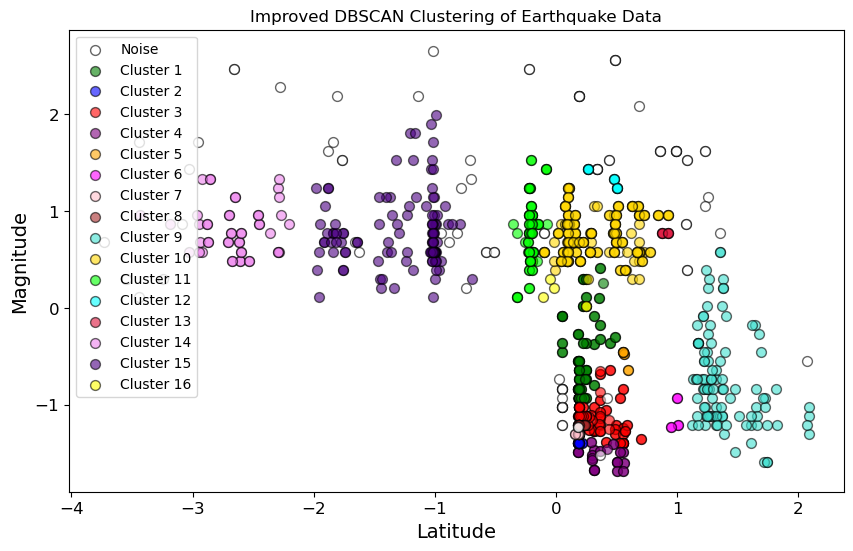

In [121]:
#Plot cell
unique_labels = X['Cluster'].unique()
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  #Exclude noise if present
colors = {
    1: 'green', 2: 'blue', 3: 'red', 4: 'purple', 5: 'orange', 6: 'magenta', 7: 'pink', 8: 'brown', 
    9: 'turquoise', 10: 'gold', 11: 'lime', 12: 'cyan', 13: 'crimson', 14: 'violet', 15: 'indigo', 16: 'yellow'
}
handles = []
labels = []

#Plot each point with a color based on its cluster label
plt.figure(figsize=(10, 6))
for label in unique_labels:
    if label == -1:
        #Plot noise points in white
        scatter = plt.scatter(X[X['Cluster'] == label]['latitude'], 
                    X[X['Cluster'] == label]['magnitude'], 
                    c='white', label='Noise', s=50, marker='o', edgecolor='k', alpha=0.6)
    else:
        #Plot clusters with different colors
        color = colors.get(label, 'gray')
        scatter = plt.scatter(X[X['Cluster'] == label]['latitude'], 
                    X[X['Cluster'] == label]['magnitude'], 
                    color=color, label=f'Cluster {int(label)}', s=50, marker='o', edgecolor='k', alpha=0.6)

    handles.append(scatter)
    labels.append(label)

sorted_labels_and_handles = sorted(zip(labels, handles), key=lambda x: (x[0] != -1, x[0]))
sorted_labels, sorted_handles = zip(*sorted_labels_and_handles)
formatted_labels = ['Noise' if label == -1 else f'Cluster {int(label)}' for label in sorted_labels]

#Labeling the plot
plt.title("Improved DBSCAN Clustering of Earthquake Data")
plt.xlabel("Latitude")
plt.ylabel("Magnitude")
plt.legend(handles=sorted_handles, labels=formatted_labels)
plt.show()